In [ ]:
import numpy as np
import mne
import os

# List of subjects
subjects = [f"S{i:02}" for i in range(1, 21)]

# Paths
error_root = '/Volumes/OrientationDecoding/bids_dir/derivatives/CrossDecode'
data_path = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/'

# Dictionary to store results
subject_data = {}

for subject in subjects:
    print(f"Processing {subject}...")

    # Load epochs
    epoch_path = os.path.join(data_path, f'sub-{subject}_miniEpochs_preprocessed-epo.fif')
    epochs_mini = mne.read_epochs(epoch_path, preload=False)

    # Path to subject's error files
    subject_dir = os.path.join(error_root, subject)
    
    error_list = []
    num_train_times = 961

    for t in range(num_train_times):
        error_file = os.path.join(subject_dir, f"{subject}_errors_{t}.npy")
        if os.path.exists(error_file):
            error_data = np.load(error_file)
            error_list.append(error_data)
        else:
            print(f"Missing: {error_file}")
            # Fallback with NaNs
            error_list.append(np.full((len(epochs_mini), len(epochs_mini.times)), np.nan))

    # Stack shape: (train_time, trials, test_time)
    error_stack = np.stack(error_list, axis=0)

    # Transpose → (trials, test_time, train_time)
    error_stack = np.transpose(error_stack, (1, 2, 0))

    subject_data[subject] = {
        'epochs_mini': epochs_mini,
        'errors': error_stack
    }

# ✅ Check one subject
for subject in subjects:
    errors = subject_data[subject]['errors']
    print(f"{subject}: error shape = {errors.shape}")  # Expect (n_trials, n_test_times, n_train_times)
    print(errors[:2, :2, :5])  # Preview: 2 trials × 2 test times × 5 train times


In [ ]:
import json

output_dir = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/!Important Data/test'
os.makedirs(output_dir, exist_ok=True)

manifest = {}
for subject in subjects:
    # Save the error array
    error_array = subject_data[subject]['errors']
    error_file_path = os.path.join(output_dir, f"{subject}_errors.npy")
    np.save(error_file_path, error_array)

    # Record in manifest
    manifest[subject] = {
        "error_file": error_file_path,
        "epochs_file": os.path.join(data_path, f'sub-{subject}_miniEpochs_preprocessed-epo.fif')
    }

# Save the manifest JSON
with open(os.path.join(output_dir, "error_manifest.json"), "w") as f:
    json.dump(manifest, f, indent=2)


In [22]:
s01_errors = subject_data["S01"]["errors"]  # shape: (n_trials, n_test_times, n_train_times)
trialmat = subject_data["S01"]["epochs_mini"].metadata

print(s01_errors.shape)

(26880, 60, 961)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

s01_errors = subject_data["S01"]["errors"]  # shape: (n_trials, n_test_times, n_train_times)
trialmat = subject_data["S01"]["epochs_mini"].metadata

tp = 55  # test timepoint index
time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()  # trial indices for this test time

# We'll collect mean errors for each training time
mean_errors = []

n_test_times = s01_errors.shape[1]
for tp in range(n_test_times):
    toplot = s01_errors[time_idx, tp].flatten()  # same structure as before
    mean_error = np.mean(np.abs(toplot))  # or np.mean(toplot) for signed
    mean_errors.append(mean_error)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(mean_errors, marker='o')
plt.xlabel("Training Time Index")
plt.ylabel("Mean Absolute Error (deg)")
plt.title(f"Mean Error at Test Time {tp} Across All Training Times")
plt.grid(True)
plt.tight_layout()
plt.show()


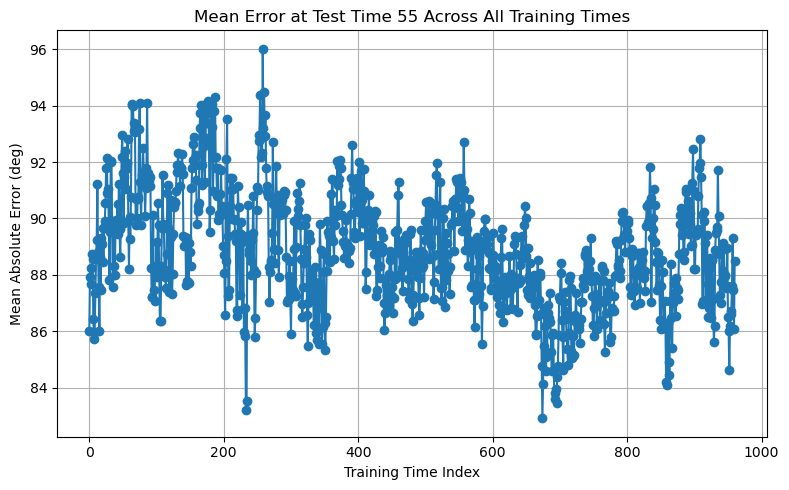

In [29]:
import numpy as np
import matplotlib.pyplot as plt

s01_errors = subject_data["S01"]["errors"]  # shape: (n_trials, n_test_times, n_train_times)
trialmat = subject_data["S01"]["epochs_mini"].metadata

tp = 55  # test timepoint index
time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()  # trial indices for this test time

# We'll collect mean errors for each training time
mean_errors = []

for train_time in range(s01_errors.shape[2]):  # loop over all training times
    toplot = s01_errors[time_idx, tp, train_time].flatten()  # same structure as before
    mean_error = np.mean(np.abs(toplot))  # or np.mean(toplot) for signed
    mean_errors.append(mean_error)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(mean_errors, marker='o')
plt.xlabel("Training Time Index")
plt.ylabel("Mean Absolute Error (deg)")
plt.title(f"Mean Error at Test Time {tp} Across All Training Times")
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
s01_errors.shape[0]

26880

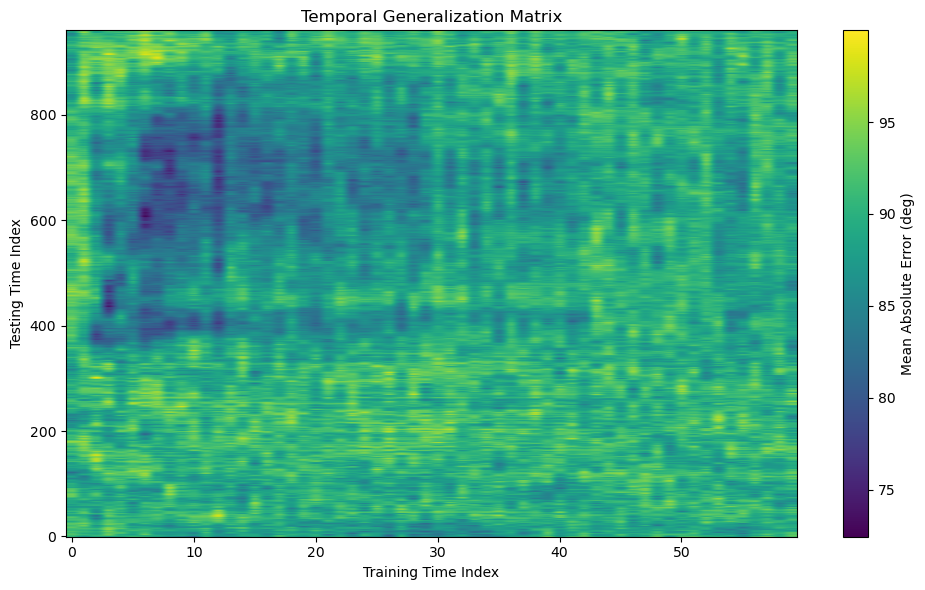

In [54]:
import numpy as np
import matplotlib.pyplot as plt

s01_errors = subject_data["S02"]["errors"]  # shape: (n_trials, n_test_times, n_train_times)
trialmat = subject_data["S02"]["epochs_mini"].metadata

n_test_times = s01_errors.shape[1]
n_train_times = s01_errors.shape[2]

# Initialize output: rows = test timepoints, columns = training timepoints
mean_errors_matrix = np.zeros((n_test_times, n_train_times))

# Loop over all test timepoints
for tp in range(n_test_times):
    time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()

    # Loop over training timepoints
    for train_time in range(n_train_times):
        toplot = s01_errors[time_idx, tp, train_time].flatten()
        mean_error = np.mean(np.abs(toplot))  # use abs for unsigned error
        mean_errors_matrix[tp, train_time] = mean_error

# ✅ Plot
plt.figure(figsize=(10, 6))
plt.imshow(mean_errors_matrix.T, origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="Mean Absolute Error (deg)")
plt.xlabel("Training Time Index")
plt.ylabel("Testing Time Index")
plt.title("Temporal Generalization Matrix")
plt.tight_layout()
plt.show()


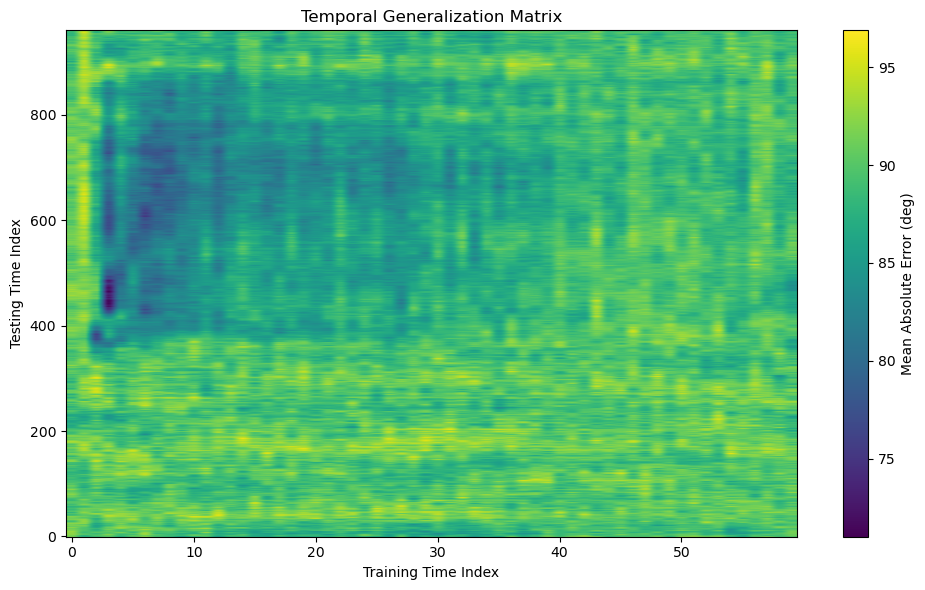

In [57]:
import numpy as np
import matplotlib.pyplot as plt

subjects = list(subject_data.keys())  # Or manually: ["S01", "S02", ..., "S20"]
example_subj = subjects[0]

# Use one subject to get dimensions
n_test_times = subject_data[example_subj]["errors"].shape[1]
n_train_times = subject_data[example_subj]["errors"].shape[2]

# Output matrix for median errors
mean_errors_matrix = np.zeros((n_test_times, n_train_times))

# Loop over test × train timepoints
for tp in range(n_test_times):
    all_toplot = {}  # cache to collect all train_time -> pooled values

    # First, collect indices once per subject
    subject_time_idx = {
        subj: subject_data[subj]["epochs_mini"].metadata[subject_data[subj]["epochs_mini"].metadata.timepoints == tp].index.to_numpy()
        for subj in subjects
    }

    for train_time in range(n_train_times):
        pooled_errors = []

        for subj in subjects:
            s_errors = subject_data[subj]["errors"]
            time_idx = subject_time_idx[subj]
            toplot = s_errors[time_idx, tp, train_time].flatten()
            pooled_errors.append(toplot)

        # Combine all subject data
        pooled = np.concatenate(pooled_errors)
        mean_errors_matrix[tp, train_time] = np.mean(np.abs(pooled))  # or mean, or std

# ✅ Plot
plt.figure(figsize=(10, 6))
plt.imshow(mean_errors_matrix.T, origin="lower", aspect="auto", cmap="viridis")
plt.colorbar(label="Mean Absolute Error (deg)")
plt.xlabel("Training Time Index")
plt.ylabel("Testing Time Index")
plt.title("Temporal Generalization Matrix")
plt.tight_layout()
plt.show()


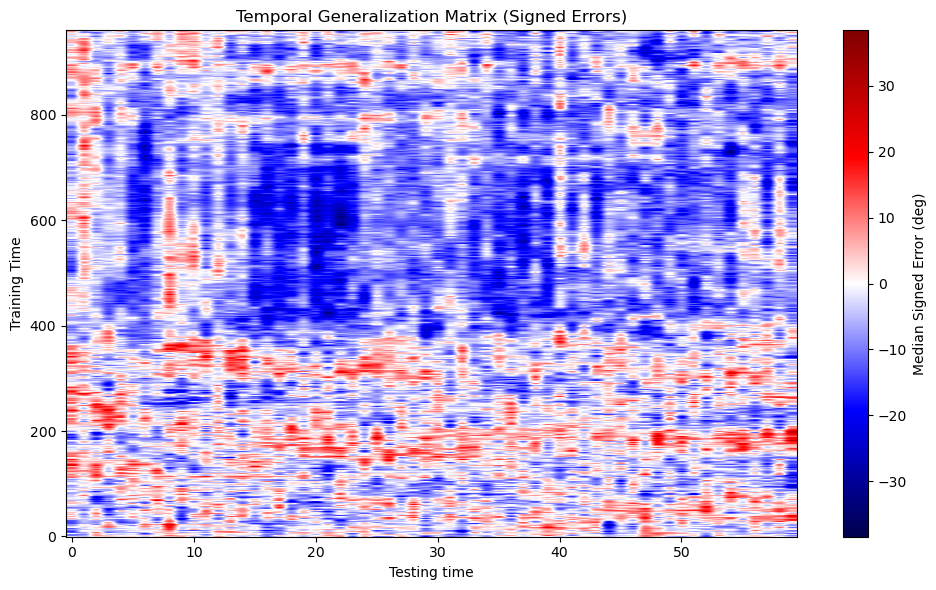

In [42]:
import numpy as np
import matplotlib.pyplot as plt

s01_errors = subject_data["S01"]["errors"]  # shape: (n_trials, n_test_times, n_train_times)
trialmat = subject_data["S01"]["epochs_mini"].metadata

n_test_times = s01_errors.shape[1]
n_train_times = s01_errors.shape[2]

# Initialize output: rows = test timepoints, columns = training timepoints
mean_errors_matrix = np.zeros((n_test_times, n_train_times))

# Loop over all test timepoints
for tp in range(n_test_times):
    time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()

    # Loop over training timepoints
    for train_time in range(n_train_times):
        toplot = s01_errors[time_idx, tp, train_time].flatten()
        mean_error = np.median(toplot)  # use abs for unsigned error
        mean_errors_matrix[tp, train_time] = mean_error

# ✅ Plot
plt.figure(figsize=(10, 6))

# Set vmin/vmax to center around 0 for signed error contrast
vmax = np.max(np.abs(mean_errors_matrix))
vmin = -vmax

plt.imshow(mean_errors_matrix.T, origin="lower", aspect="auto", cmap="seismic", vmin=vmin, vmax=vmax)
plt.colorbar(label="Median Signed Error (deg)")
plt.xlabel("Testing time")
plt.ylabel("Training Time")
plt.title("Temporal Generalization Matrix (Signed Errors)")
plt.tight_layout()
plt.show()



Shape of mean_errors_matrix: (60, 961)


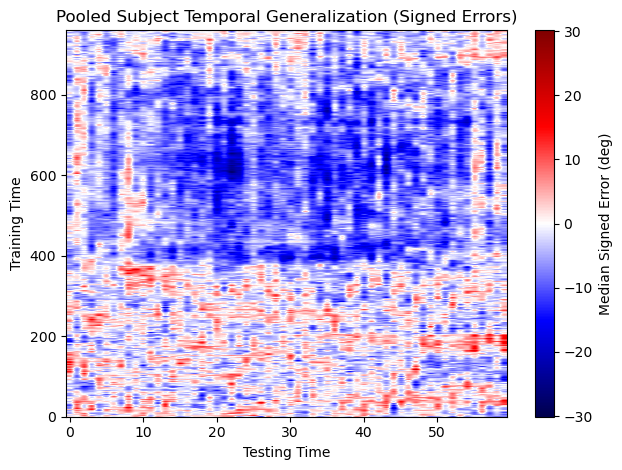

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

subjects = list(subject_data.keys())  # Or manually: ["S01", "S02", ..., "S20"]
example_subj = subjects[0]

# Use one subject to get dimensions
n_test_times = subject_data[example_subj]["errors"].shape[1]
n_train_times = subject_data[example_subj]["errors"].shape[2]

# Output matrix for median errors
mean_errors_matrix = np.zeros((n_test_times, n_train_times))

# Loop over test × train timepoints
for tp in range(n_test_times):
    all_toplot = {}  # cache to collect all train_time -> pooled values

    # First, collect indices once per subject
    subject_time_idx = {
        subj: subject_data[subj]["epochs_mini"].metadata[subject_data[subj]["epochs_mini"].metadata.timepoints == tp].index.to_numpy()
        for subj in subjects
    }

    for train_time in range(n_train_times):
        pooled_errors = []

        for subj in subjects:
            s_errors = subject_data[subj]["errors"]
            time_idx = subject_time_idx[subj]
            toplot = s_errors[time_idx, tp, train_time].flatten()
            pooled_errors.append(toplot)

        # Combine all subject data
        pooled = np.concatenate(pooled_errors)
        mean_errors_matrix[tp, train_time] = np.median(pooled)  # or mean, or std

# ✅ Plot
plt.figure(figsize=(10, 6))
vmax = np.max(np.abs(mean_errors_matrix))
vmin = -vmax

plt.imshow(mean_errors_matrix.T, origin="lower", aspect="auto", cmap="seismic", vmin=vmin, vmax=vmax)
plt.colorbar(label="Median Signed Error (deg)")
plt.xlabel("Testing Time")
plt.ylabel("Training Time")
plt.title("Pooled Subject Temporal Generalization (Signed Errors)")
plt.tight_layout()
plt.show()

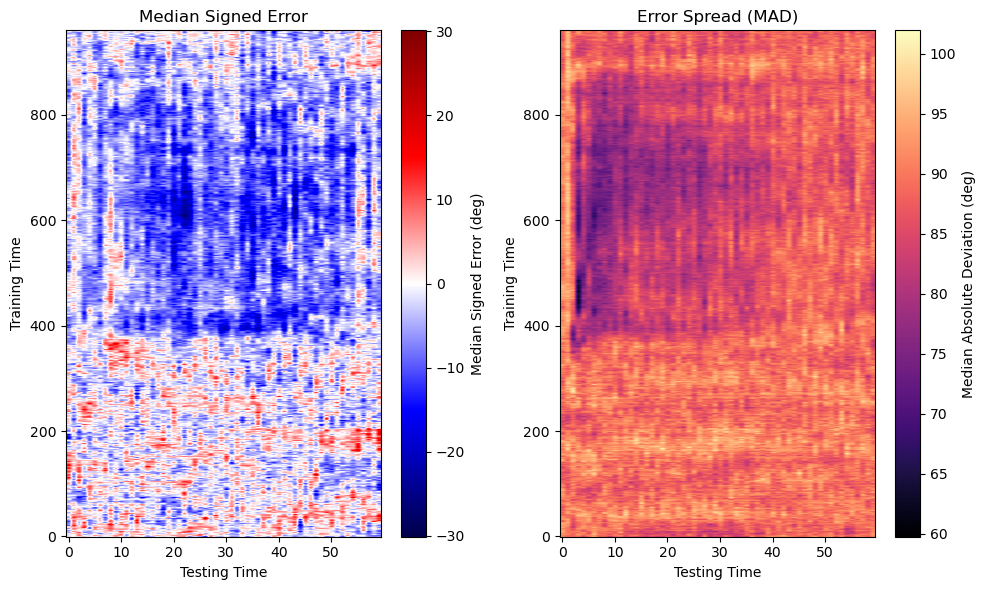

In [49]:
import numpy as np
import matplotlib.pyplot as plt

subjects = list(subject_data.keys())  # e.g. ["S01", "S02", ..., "S20"]
example_subj = subjects[0]

n_test_times = subject_data[example_subj]["errors"].shape[1]
n_train_times = subject_data[example_subj]["errors"].shape[2]

# Output matrices
median_errors_matrix = np.zeros((n_test_times, n_train_times))
mad_errors_matrix = np.zeros((n_test_times, n_train_times))  # concentration/spread metric

for tp in range(n_test_times):
    subject_time_idx = {
        subj: subject_data[subj]["epochs_mini"].metadata[subject_data[subj]["epochs_mini"].metadata.timepoints == tp].index.to_numpy()
        for subj in subjects
    }

    for train_time in range(n_train_times):
        pooled_errors = []

        for subj in subjects:
            s_errors = subject_data[subj]["errors"]
            time_idx = subject_time_idx[subj]
            toplot = s_errors[time_idx, tp, train_time].flatten()
            pooled_errors.append(toplot)

        pooled = np.concatenate(pooled_errors)
        median_errors_matrix[tp, train_time] = np.median(pooled)

        # Calculate MAD: median of absolute deviations from median
        mad = np.median(np.abs(pooled - np.median(pooled)))
        mad_errors_matrix[tp, train_time] = mad

# Plot median errors matrix
plt.figure(figsize=(10, 6))
vmax = np.max(np.abs(median_errors_matrix))
vmin = -vmax

plt.subplot(1, 2, 1)
plt.imshow(median_errors_matrix.T, origin="lower", aspect="auto", cmap="seismic", vmin=vmin, vmax=vmax)
plt.colorbar(label="Median Signed Error (deg)")
plt.xlabel("Testing Time")
plt.ylabel("Training Time")
plt.title("Median Signed Error")

# Plot MAD (spread/concentration)
plt.subplot(1, 2, 2)
plt.imshow(mad_errors_matrix.T, origin="lower", aspect="auto", cmap="magma")
plt.colorbar(label="Median Absolute Deviation (deg)")
plt.xlabel("Testing Time")
plt.ylabel("Training Time")
plt.title("Error Spread (MAD)")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

s01_errors = subject_data["S01"]["errors"]  # shape: (n_trials, n_test_times, n_train_times)
trialmat = subject_data["S01"]["epochs_mini"].metadata

n_test_times = s01_errors.shape[1]
n_train_times = s01_errors.shape[2]

chosen_train_time = 420  # <-- change this to any training time index you want

angle_error = np.arange(-180, 185, 5)

# Loop over test timepoints to generate histograms
for tp in range(n_test_times):
    time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()
    toplot = s01_errors[time_idx, tp, chosen_train_time].flatten()

    counts, bin_edges = np.histogram(toplot, bins=angle_error)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=5, edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of Errors | Train time: {chosen_train_time}, Test time: {tp}")
    plt.xlabel("Signed Error (deg)")
    plt.ylabel("Count")
    plt.xticks(np.arange(-180, 181, 60))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

subjects = list(subject_data.keys())  # ["S01", "S02", ..., "S20"]
example_subj = subjects[0]

n_test_times = subject_data[example_subj]["errors"].shape[1]
n_train_times = subject_data[example_subj]["errors"].shape[2]

chosen_train_time = 420  # <-- Change this as needed
angle_error = np.arange(-180, 185, 5)  # Histogram bins

# Pre-compute time indices per subject
subject_time_idx = {
    subj: subject_data[subj]["epochs_mini"].metadata[
        subject_data[subj]["epochs_mini"].metadata.timepoints == tp
    ].index.to_numpy()
    for subj in subjects
    for tp in range(n_test_times)
}

# Loop over test timepoints
for tp in range(n_test_times):
    pooled_errors = []

    for subj in subjects:
        s_errors = subject_data[subj]["errors"]
        time_idx = subject_data[subj]["epochs_mini"].metadata[
            subject_data[subj]["epochs_mini"].metadata.timepoints == tp
        ].index.to_numpy()
        toplot = s_errors[time_idx, tp, chosen_train_time].flatten()
        pooled_errors.append(toplot)

    pooled = np.concatenate(pooled_errors)

    # Histogram
    counts, bin_edges = np.histogram(pooled, bins=angle_error)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    plt.figure(figsize=(8, 4))
    plt.bar(bin_centers, counts, width=5, edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of Pooled Errors | Train: {chosen_train_time}, Test: {tp}")
    plt.xlabel("Signed Error (deg)")
    plt.ylabel("Count")
    plt.xticks(np.arange(-180, 181, 60))
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()


In [7]:
import os
import numpy as np

# Path to the subject's output files
subject = 'S01'
train_time = 30  # or whatever timepoint you used
subject_dir = f'/Volumes/OrientationDecoding/bids_dir/derivatives/CrossDecode/{subject}'

# Construct full paths to files
pred_path = os.path.join(subject_dir, f'{subject}_predictions_{train_time}.npy')
true_path = os.path.join(subject_dir, f'{subject}_true_{train_time}.npy')
error_path = os.path.join(subject_dir, f'{subject}_errors_{train_time}.npy')

# Load files and print shape info
if os.path.exists(pred_path):
    preds = np.load(pred_path)
    print(f"Predictions shape: {preds.shape}")  # Expected: (n_trials, n_timepoints)
    print("Predictions (first row):", preds[0])
else:
    print("Predictions file not found.")

if os.path.exists(true_path):
    trues = np.load(true_path)
    print(f"True values shape: {trues.shape}")  # Expected: (n_trials,)
    print("True values (first 10):", trues[:10])
else:
    print("True values file not found.")

if os.path.exists(error_path):
    errors = np.load(error_path)
    print(f"Errors shape: {errors.shape}")  # Expected: (n_trials, n_timepoints)
    print("Errors (first row):", errors[0])
else:
    print("Errors file not found.")


Predictions shape: (26880, 60)
Predictions (first row): [332.35506006  48.23181763 103.25481285 123.51396628 148.89598252
 113.43172329 118.24629149 146.36147678 201.87809067 261.53052927
  12.53965695 284.31584955 255.76083522 219.11195657 134.19935021
 149.25461527 188.0523114  189.97380577 109.09783955 100.63723413
 141.97357451 161.26997766 132.50013359 109.27919945 139.15408527
 168.33850651 141.86899744  94.3859407   86.31397964 115.66769765
 122.01334987 111.85550635 115.75879076 169.15318869 169.25986773
 159.09723786 156.89519869 161.22749446 160.47457795 147.10962652
 136.04668099 131.73285685 116.17629325  98.48240964 105.32475293
 137.44914258 149.18395805 149.47062272 148.20490542 136.89149781
 127.81541018 134.34132532 142.2200171  112.09786333  78.32651289
  69.07695886  77.90627042 159.7865597  158.45637123 156.57646586]
True values shape: (26880,)
True values (first 10): [ 22.  22. 112. 157.  67. 202. 247. 112. 157.  67.]
Errors shape: (26880, 60)
Errors (first row): [

In [2]:
import numpy as np
import mne 

subjects = [f"S{i:02}" for i in range(1, 2)]
# load data [NOTE @Sebastian: derivatives should be in bids_dir, i.e. "..../Data/Bids/bids_dir" to be compatible]
bids_dir = '/System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/'
data_path = f'{bids_dir}derivatives/preprocessed/'
# Dictionary to store data for each subject
subject_data = {}

for Subject in subjects:
    fn_miniepochs = f'sub-{Subject}_miniEpochs_preprocessed-epo.fif'
    
    epochs_mini = mne.read_epochs(data_path + fn_miniepochs)
    errors = np.load(error_path)
    
    subject_data[Subject] = {
        'epochs_mini': epochs_mini,
        'errors': errors
    }

# Print shape and first few lines of errors arrays for comparison
for Subject in subjects:
    errors = subject_data[Subject]['errors']
    print(f"Subject {Subject}: Shape {errors.shape}")
    print(errors[:5])  # Print first 5 lines for inspection

Reading /System/Volumes/Data/misc/data12/sjapee/Sebastian-OrientationImagery/Data/Bids/derivatives/preprocessed/sub-S01_miniEpochs_preprocessed-epo.fif ...
    Found the data of interest:
        t =       0.00 ...      49.17 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
26880 matching events found
No baseline correction applied
0 projection items activated
Subject S01: Shape (26880, 60)
[[  49.64493994  -26.23181763  -81.25481285 -101.51396628 -126.89598252
   -91.43172329  -96.24629149 -124.36147678 -179.87809067  120.46947073
     9.46034305   97.68415045  126.23916478  162.88804343 -112.19935021
  -127.25461527 -166.0523114  -167.97380577  -87.09783955  -78.63723413
  -119.97357451 -139.26997766 -110.50013359  -87.27919945 -117.15408527
  -146.33850651 -119.86899744  -72.3859407   -64.31397964  -93.66769765
  -100.01334987  -89.85550635  -93.75879076 -147.15318869 -147.25986773
  -137.09723786 -134.89519869 -139.22749446 -138.47457795 -125.10962652

In [3]:
s01_errors = subject_data["S01"]["errors"]
trialmat = subject_data["S01"]["epochs_mini"].metadata

In [6]:
print(trialmat.timepoints)

0         0
1         0
2         0
3         0
4         0
         ..
26875    59
26876    59
26877    59
26878    59
26879    59
Name: timepoints, Length: 26880, dtype: int64


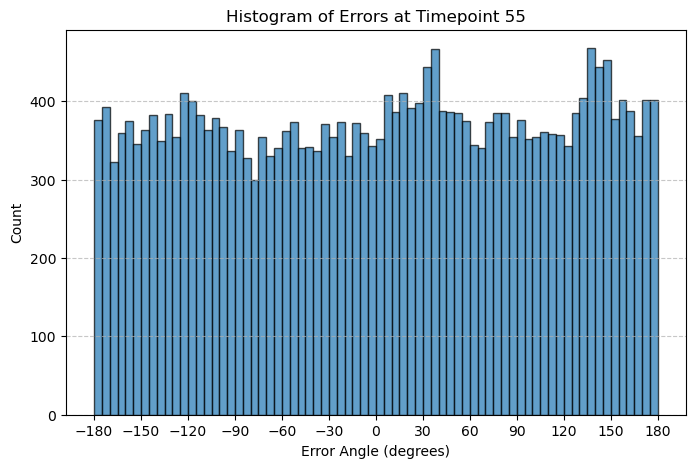

In [5]:
import numpy as np
import matplotlib.pyplot as plt

s01_errors = subject_data["S01"]["errors"]
trialmat = subject_data["S01"]["epochs_mini"].metadata

tp = 55

time_idx = trialmat[trialmat.timepoints == tp].index.to_numpy()
toplot = s01_errors[time_idx, :].flatten()

angle_error = np.arange(-180, 185, 5)

counts, bin_edges = np.histogram(toplot, bins=angle_error)

# Compute bin centers for proper plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Plot histogram
plt.figure(figsize=(8, 5))
plt.bar(bin_centers, counts, width=5, edgecolor="black", alpha=0.7)
plt.xlabel("Error Angle (degrees)")
plt.ylabel("Count")
plt.title(f"Histogram of Errors at Timepoint {tp}")
plt.xticks(np.arange(-180, 181, 30))  # Adjust x-axis ticks for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
